## Descriptive statistics

In [1]:
# General
# import glob
import os.path
# import warnings
# warnings.filterwarnings('ignore')
from tqdm import tqdm
import copy

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# # from matplotlib.colors import Normalize
# # from matplotlib.colors import ListedColormap
# # import matplotlib.cm as cm
import pandas as pd

# PyTorch
import torch
import torch.nn as nn
from torch.autograd import Variable              # Convert arrays to tensors
from torch.utils.data import Dataset, DataLoader # Create a Dataset class to combine with DataLoader (= mini batches selection)
import pytorch_lightning as pl

# Data treatment
# import dask as da
# from dask.diagnostics import ProgressBar
# import zarr
# from scipy.interpolate import griddata
from datetime import datetime
from sklearn.linear_model import LinearRegression

# Custom
import functions as f

# Statistics
from sklearn import linear_model, neighbors
from pykalman import KalmanFilter

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
### Setup device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))
print('{} GPU(s) available'.format(torch.cuda.device_count()))

Using cuda device
1 GPU(s) available


In [3]:
### VARIABLES TO CONSIDER
'''Initial dataset has 147 variables, so we select only a subset of these'''
# storm speed, time, dist2land, usa_r64, usa_r50
params_of_interest = ['usa_lon', 'usa_lat', 'usa_wind', 'usa_r34', 'usa_rmw', 'storm_speed', 'storm_dir'] 
additional_info    = ['numobs', 'sid', 'basin', 'name', 'usa_agency', 'iso_time', 'usa_status']

### PARAMS
PARAMS = {'fcor_boost' : 1,         
         }

### PATHS
PATHS  = {
    # Data
    'ibtracs_data': '/home/arthur/data/ibtracs/IBTrACS.ALL.v04r00.nc', # '/home/arthur/data/ibtracs/IBTrACS.NA.v04r00.nc'
    # Save
    'save_path':     '/home/arthur/results/TCsLifeMonitFromObs/descriptive_stats/',
    'save_csv_path': '/home/arthur/results/TCsLifeMonitFromObs/descriptive_stats/csv_files/',
}

In [4]:
### OPEN DATASET
ds_ibt_raw = xr.open_dataset(PATHS['ibtracs_data'])
ds_ibt     = ds_ibt_raw[params_of_interest + additional_info]
# ds_ibt_raw

In [5]:
# ### FILTERS
# # Convert to m/s and km units
# ds_ibt['usa_wind']    *= 0.5144
# ds_ibt['storm_speed'] *= 0.5144
# ds_ibt['usa_r34']     *= 1.852
# ds_ibt['usa_rmw']     *= 1.852

# ### 1) FILTERS BY YEAR, EMPTY R34, CATEGORY, RMAX INTERESTING TIME SERIES
# # By year
# start_date = np.datetime64('2000-01-01')
# fsi        = np.nanargmin(np.abs(ds_ibt['time'][:, 0] - start_date)) # First storm index
# ds_ibt     = ds_ibt.isel(storm=slice(fsi, -1))
# # Average by quadrant (R34 assumption)
# # ds_ibt     = ds_ibt.mean(dim='quadrant', skipna=True) # Relax this assumption to study the asymmetry
# # By category
# for s in tqdm(range(len(ds_ibt['storm']))):
#     da = ds_ibt.isel(storm=s)['usa_wind']
#     if da.max(dim='date_time', skipna=True) < 33: # >= Cat.1 according to Saffir Simpson scale, 64 is in knts
#         ds_ibt.isel(storm=s)['usa_wind'] *= np.nan  

# # # Keep only interesting time series, i.e containing sufficiently long sequences of valid Rmax values
# for s in tqdm(range(len(ds_ibt['storm']))):
#     da = ds_ibt.isel(storm=s)['usa_rmw']
#     # Longest valid sequence
#     # if np.max(np.diff(np.where(np.isnan(da)))) < 8: # Count maximum valid sequence and filter it out if less than 1 day
#     #     ds_ibt.isel(storm=s)['usa_rmw'] *= np.nan
#     # Number of valid values
#     if np.count_nonzero(~np.isnan(da)) < 24: # Count the number of valid usa_rmw values and filter it out if less than 24 values
#         ds_ibt.isel(storm=s)['usa_rmw'] *= np.nan   
# # Drop NaNs
# ds_ibt = ds_ibt.dropna(dim='storm', how='all', subset=['usa_wind']) # Much quicker to drop NaNs only at the end
# ds_ibt = ds_ibt.dropna(dim='storm', how='all', subset=['usa_rmw']) 
# ds_ibt = ds_ibt.dropna(dim='storm', how='all', subset=['usa_r34'])

# print("Total samples after (1): ", len(ds_ibt['storm']))

# ### 2) FINAL DATASET
# ### Keep longest valid sequence if it represents more than 60% of the TC life cycle
# # Both for RMW and R34
# life_cyc_percent_thresh = 0.6

# for s in tqdm(range(len(ds_ibt['storm']))):
#         ds      = ds_ibt.isel(storm=s)
#         # Compute life cycle length
#         cyc_len = np.where(np.isnan(ds['usa_lat']))[0][0]
#         for param in ['usa_r34', 'usa_rmw']:
#         # for param in ['usa_rmw']:
#             # Compute length of longest valid sequence
#             val_len = np.max(np.diff(np.concatenate(([0], np.where(np.isnan(ds[param]))[0]), axis=0)))
#             if val_len < life_cyc_percent_thresh * cyc_len:
#                 # print('Index {}, Cyc_len = {}, val_len = {}'.format(s, cyc_len, val_len))
#                 ds[param] *= np.nan
                
# ds_ibt = ds_ibt.dropna(dim='storm', how='all', subset=['usa_rmw']) 
# ds_ibt = ds_ibt.dropna(dim='storm', how='all', subset=['usa_r34'])

# print("Total samples after (2): ", len(ds_ibt['storm'])) 

# ### 3) ADD CORIOLIS
# ds_ibt['fcor'] = f.coriolis(np.abs(ds_ibt['usa_lat'])) * PARAMS['fcor_boost']
                
# ### 4) FLIP TCs of Southern hemisphere
# ### Take the symmetric with respect to Equator
# ### So storm_dir = PI - storm_dir
# ds_ibt.where(ds_ibt['lat'] < 0)['storm_dir'] = 180 - ds_ibt['storm_dir']
# # Then project to (u, v) ref.
# ds_ibt['u_trans'] = ds_ibt['storm_speed'] * np.sin(np.deg2rad(ds_ibt['storm_dir']))
# ds_ibt['v_trans'] = ds_ibt['storm_speed'] * np.cos(np.deg2rad(ds_ibt['storm_dir']))
# # plt.hist(np.array(ds_ibt['u_trans']).flatten()) # Check gaussianity

# ### 5) COMPUTE RMAX_CK22
# ds_ibt['rmax_ck22'] = f.get_rmax_ck22(
#     Vmax=ds_ibt['usa_wind'], R17=ds_ibt['usa_r34'], fcor=f.coriolis(np.abs(ds_ibt['usa_lat'])), 
#     intercept=0.459, coef1=0.00534, coef2=-0.00337
# ) / 1000

In [6]:
# ### SAVE
# ds_ibt.to_netcdf(PATHS['save_path'] + 'ds_ibtracs_NA.nc')

In [7]:
# ### OPEN
ds_ibt = xr.open_dataset(PATHS['save_path'] + 'ds_ibtracs_ALL.nc')
# ds_ibt

(array([2.4307e+04, 5.5220e+03, 8.8300e+02, 2.1600e+02, 5.3000e+01,
        2.7000e+01, 2.0000e+00, 3.0000e+00, 1.0000e+00, 2.0000e+00]),
 array([  0.      ,  40.092667,  80.18533 , 120.278   , 160.37067 ,
        200.46333 , 240.556   , 280.64868 , 320.74133 , 360.83398 ,
        400.92667 ], dtype=float32),
 <BarContainer object of 10 artists>)

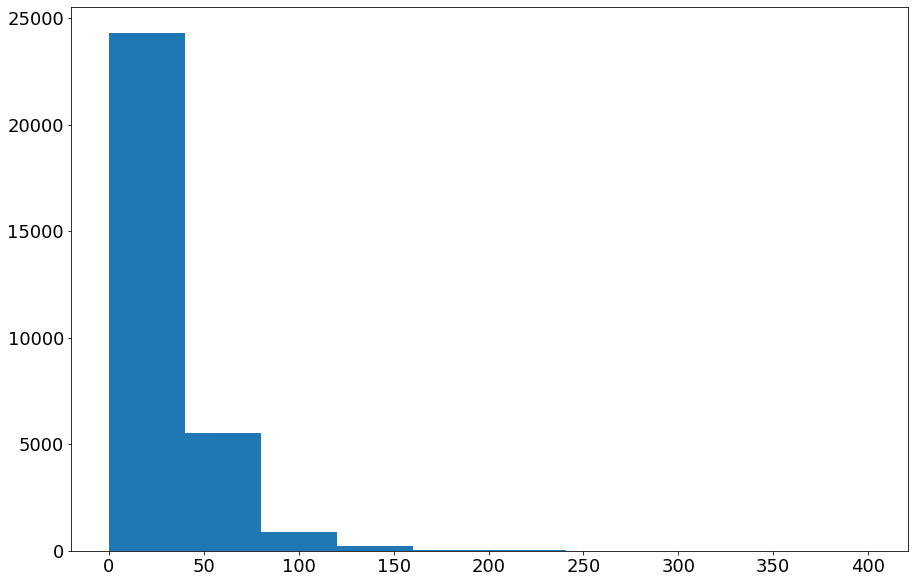

In [8]:
plt.hist(np.array(ds_ibt['usa_r34'].std(dim='quadrant', skipna=True)).flatten())

/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:733: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


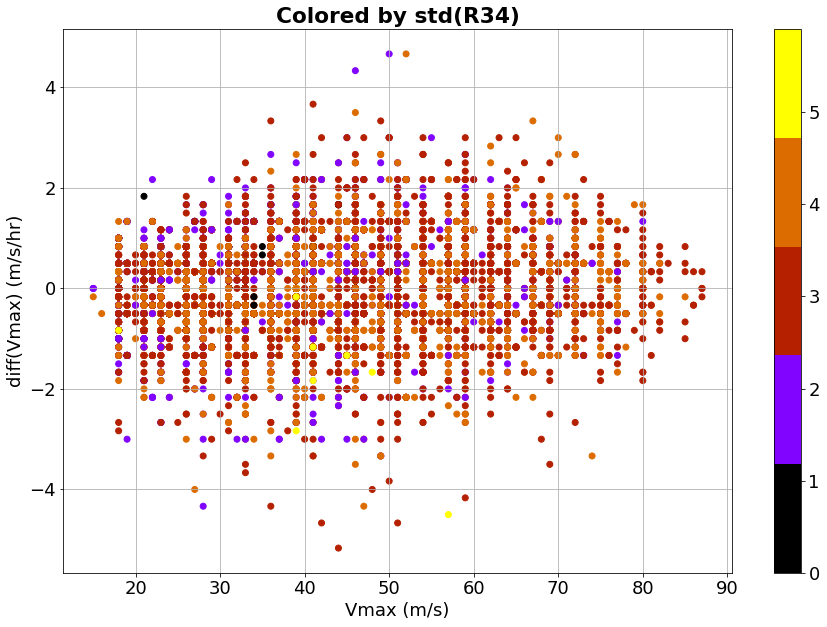

In [9]:
cmap       = cm.get_cmap('gnuplot', 5)

vmaxs      = np.array(ds_ibt['usa_wind'])
vmaxs_diff = np.gradient(vmaxs, 3, axis=1)

plt.scatter(vmaxs, vmaxs_diff, c=np.log(ds_ibt['usa_r34'].std(dim='quadrant', skipna=True)), cmap=cmap)

plt.title('Colored by std(R34)', weight='bold')
plt.xlabel('Vmax (m/s)');plt.ylabel('diff(Vmax) (m/s/hr)')
plt.grid();plt.colorbar()

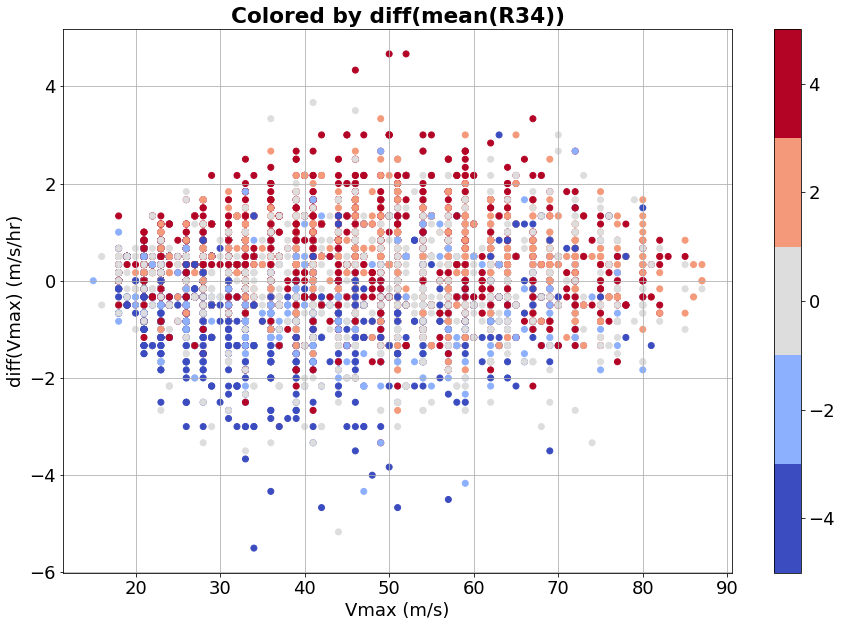

In [10]:
cmap       = cm.get_cmap('coolwarm', 5)

vmaxs      = np.array(ds_ibt['usa_wind'])
vmaxs_diff = np.gradient(vmaxs, 3, axis=1)
r34s       = np.array(ds_ibt['usa_r34'].mean(dim='quadrant', skipna=True))
r34s_diff  = np.gradient(r34s, 3, axis=1)

plt.scatter(vmaxs, vmaxs_diff, c=r34s_diff, vmin=-5, vmax=5, cmap=cmap)

plt.title('Colored by diff(mean(R34))', weight='bold')
plt.xlabel('Vmax (m/s)');plt.ylabel('diff(Vmax) (m/s/hr)')
plt.grid();plt.colorbar()

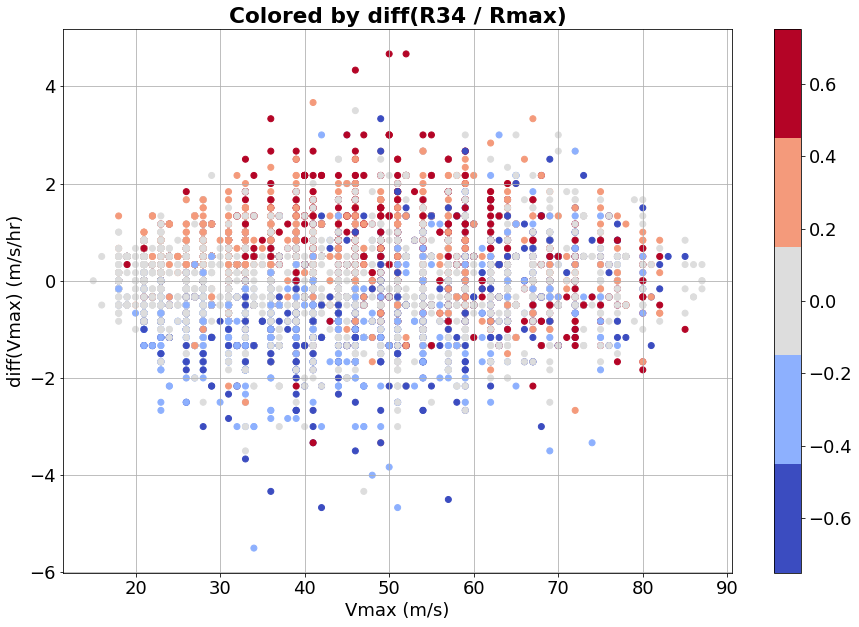

In [11]:
cmap       = cm.get_cmap('coolwarm', 5)

vmaxs      = np.array(ds_ibt['usa_wind'])
vmaxs_diff = np.gradient(vmaxs, 3, axis=1)
r34_rmaxs  = np.array(ds_ibt['usa_r34'].mean(dim='quadrant', skipna=True) / ds_ibt['usa_rmw'])
r34_rmaxs_diff = np.gradient(r34_rmaxs, 3, axis=1)

plt.scatter(vmaxs, vmaxs_diff, c=r34_rmaxs_diff, vmin=-0.75, vmax=0.75, cmap=cmap)

plt.title('Colored by diff(R34 / Rmax)', weight='bold')
plt.xlabel('Vmax (m/s)');plt.ylabel('diff(Vmax) (m/s/hr)')
plt.grid();plt.colorbar()

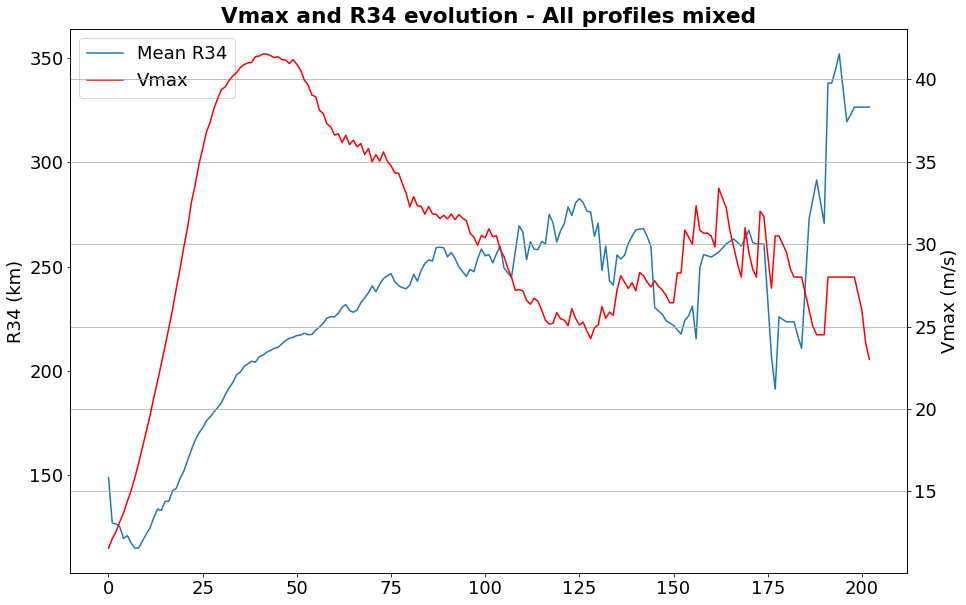

In [12]:
# BRUTE-FORCE APPROACH
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
plt.title('Vmax and R34 evolution - All profiles mixed', weight='bold')
l1  = ax1.plot(ds_ibt['usa_r34'].mean(dim='quadrant', skipna=True).mean(dim='storm', skipna=True), c='tab:blue', label='Mean R34')
l2  = ax2.plot(ds_ibt['usa_wind'].mean(dim='storm', skipna=True), c='r', label='Vmax')
plt.xlabel('datetime');ax1.set_ylabel('R34 (km)');ax2.set_ylabel('Vmax (m/s)')
plt.grid();ax1.legend(l1 + l2, [l1[0].get_label(), l2[0].get_label()], loc=0)

In [13]:
### COMPUTE v* AND t*
ds_ibt['v_star']     = ds_ibt['usa_wind'].max(dim='date_time', skipna=True)
v_star_idxs          = ds_ibt['usa_wind'].argmax(dim='date_time', skipna=True)
ds_ibt['t_star_idx'] = v_star_idxs
ds_ibt['t_star']     = ds_ibt['time'][:, v_star_idxs]

### COMPUTE DELTA
ds_ibt['delta']           = ds_ibt['numobs'] * 0
ds_ibt['delta_left_idx']  = ds_ibt['numobs'] * 0
ds_ibt['delta_right_idx'] = ds_ibt['numobs'] * 0
ds_ibt['first_valid_idx'] = ds_ibt['numobs'] * 0
thresh = 0.9
for s in tqdm(range(len(ds_ibt.storm))):
    ds = ds_ibt.isel(storm=s)
    ds_ibt['delta'][s]           = len(np.where(~np.isnan(ds['usa_wind'].where(ds['usa_wind'] >= thresh * ds['v_star'])))[0])
    ds_ibt['delta_left_idx'][s]  = int(np.where(~np.isnan(ds['usa_wind'].where(ds['usa_wind'] >= thresh * ds['v_star'])))[0][0])
    ds_ibt['delta_right_idx'][s] = int(np.where(~np.isnan(ds['usa_wind'].where(ds['usa_wind'] >= thresh * ds['v_star'])))[0][-1])
    ds_ibt['first_valid_idx'][s] = int(np.where(~np.isnan(ds['usa_wind']))[0][0])

### MAKE ALL SAMPLES HAVE THE SAME SIZE
ds_ibt['mean_r34']       = ds_ibt['usa_r34'].mean(dim='quadrant', skipna=True) # mean R34
ds_ibt['mean_rmax_ck22'] = ds_ibt['rmax_ck22'].mean(dim='quadrant', skipna=True) # mean R34
ds_temp  = ds_ibt.where(ds_ibt['delta_left_idx'] - ds_ibt['first_valid_idx'] >= 20, drop=True) # Delete sequences where end idx is lower than seq_len
_, idxs  = xr.broadcast(ds_temp.storm, ds_temp.date_time)
ds_temp  = ds_temp.assign_coords(idx=idxs)
ds_final = ds_temp.isel(date_time=slice(0, 20 + 80)).copy(deep=True)
ds_final.drop(['time', 'lon', 'lat'])
for s in tqdm(range(len(ds_temp.storm))):
    ds = ds_temp.isel(storm=s)
    for var in ['usa_wind', 'mean_r34', 'usa_rmw', 'usa_lat', 'mean_rmax_ck22', 'storm_dir', 'storm_speed', 'lon', 'lat']:
        ds_final[var][s, :] = ds[var][int(ds.delta_left_idx) - 20:int(ds.delta_left_idx) + 80]

100%|████████████████████████████████████████| 503/503 [00:02<00:00, 171.05it/s]


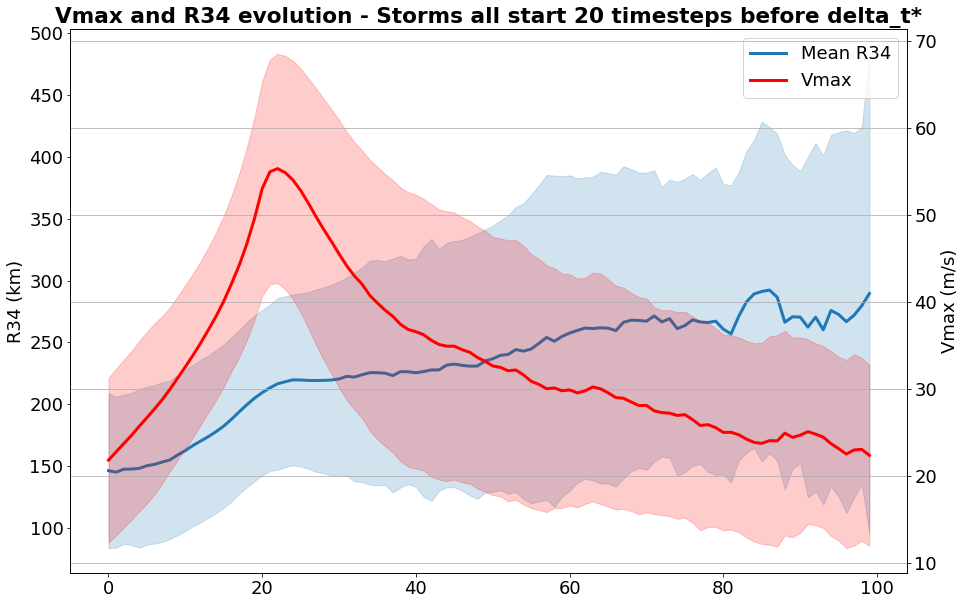

In [14]:
# Between t* and t* - 20 timesteps, where t* is the timestep when Vmax reaches 90% of max(Vmax)
r34_mean   = ds_final['mean_r34'].mean(dim='storm', skipna=True)
r34_std    = ds_final['mean_r34'].std(dim='storm', skipna=True)
vmax_mean  = ds_final['usa_wind'].mean(dim='storm', skipna=True)
vmax_std   = ds_final['usa_wind'].std(dim='storm', skipna=True)
rck22_mean = ds_final['mean_rmax_ck22'].mean(dim='storm', skipna=True)
rmax_mean  = ds_final['usa_rmw'].mean(dim='storm', skipna=True)
rmax_std   = ds_final['usa_rmw'].std(dim='storm', skipna=True)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
plt.title('Vmax and R34 evolution - Storms all start 20 timesteps before delta_t*', weight='bold')
l1  = ax1.plot(r34_mean, linewidth=3, c='tab:blue', label='Mean R34')
l2  = ax2.plot(vmax_mean, linewidth=3, c='r', label='Vmax')
ax1.fill_between(np.arange(len(r34_mean)), r34_mean + r34_std, r34_mean - r34_std, alpha=0.2, color='tab:blue')
ax2.fill_between(np.arange(len(vmax_mean)), vmax_mean + vmax_std, vmax_mean - vmax_std, alpha=0.2, color='r')
plt.xlabel('datetime');ax1.set_ylabel('R34 (km)');ax2.set_ylabel('Vmax (m/s)')
plt.grid();ax1.legend(l1 + l2, [l1[0].get_label(), l2[0].get_label()], loc=0)

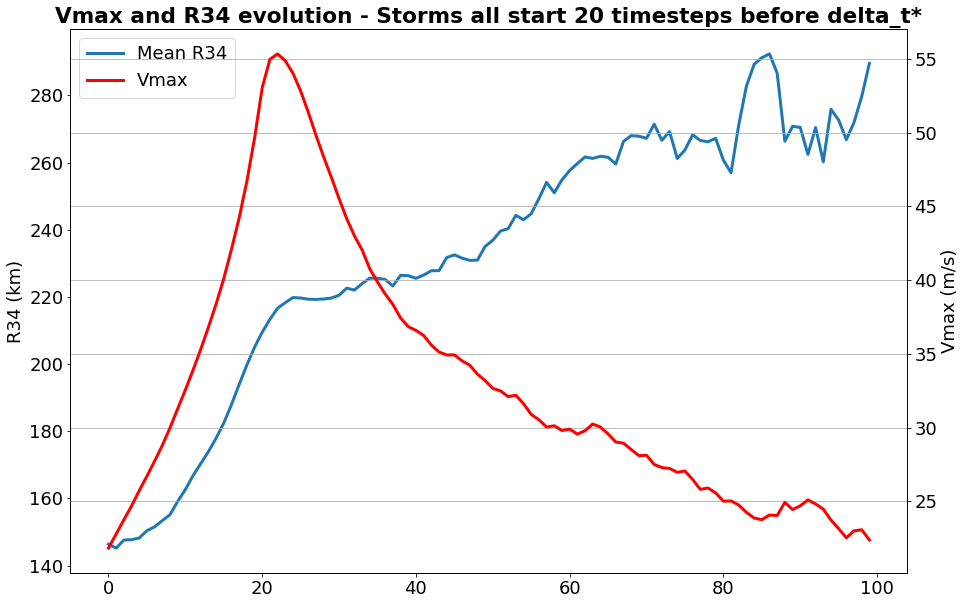

In [15]:
### SAME WITHOUT STD
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
plt.title('Vmax and R34 evolution - Storms all start 20 timesteps before delta_t*', weight='bold')
l1  = ax1.plot(r34_mean, linewidth=3, c='tab:blue', label='Mean R34')
l2  = ax2.plot(vmax_mean, linewidth=3, c='r', label='Vmax')
plt.xlabel('datetime');ax1.set_ylabel('R34 (km)');ax2.set_ylabel('Vmax (m/s)')
plt.grid();ax1.legend(l1 + l2, [l1[0].get_label(), l2[0].get_label()], loc=0)

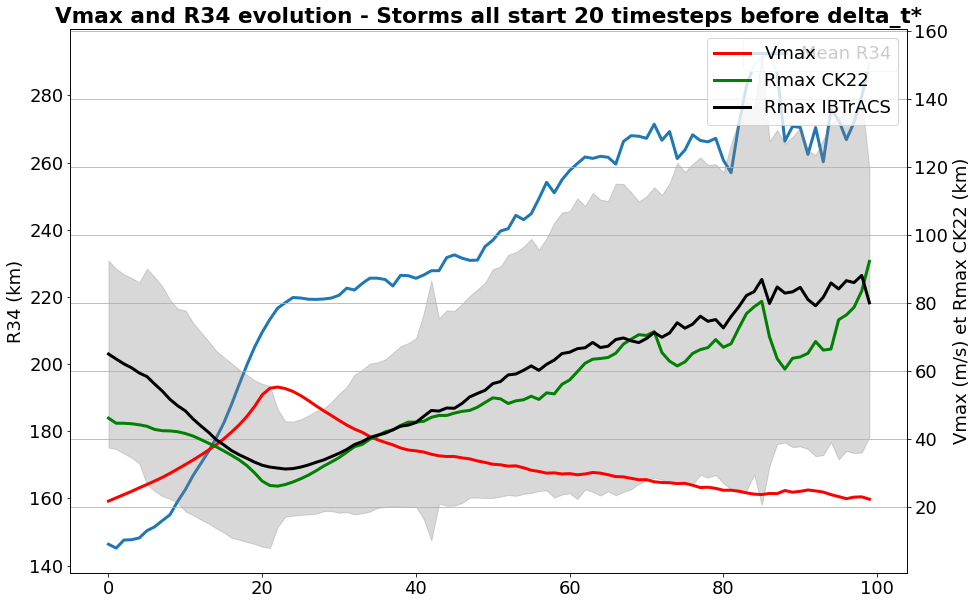

In [16]:
### SAME WITHOUT STD
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
plt.title('Vmax and R34 evolution - Storms all start 20 timesteps before delta_t*', weight='bold')
l1  = ax1.plot(r34_mean, linewidth=3, c='tab:blue', label='Mean R34')
l2  = ax2.plot(vmax_mean, linewidth=3, c='r', label='Vmax')
ax2.plot(rck22_mean, linewidth=3, c='g', label='Rmax CK22')
ax2.plot(rmax_mean, linewidth=3, c='k', label='Rmax IBTrACS')
ax2.fill_between(np.arange(len(rmax_mean)), rmax_mean + rmax_std, rmax_mean - rmax_std, alpha=0.3, color='grey')
ax2.legend(loc=0);ax1.legend(loc=1)
plt.xlabel('datetime');ax1.set_ylabel('R34 (km)');ax2.set_ylabel('Vmax (m/s) et Rmax CK22 (km)')
plt.grid()

/home/arthur/scripts/TCsLifeMonitFromObs/functions.py:23: RuntimeWarning: invalid value encountered in power
  return (0.5 * Ck_Cd) ** (1 / (2 - Ck_Cd))


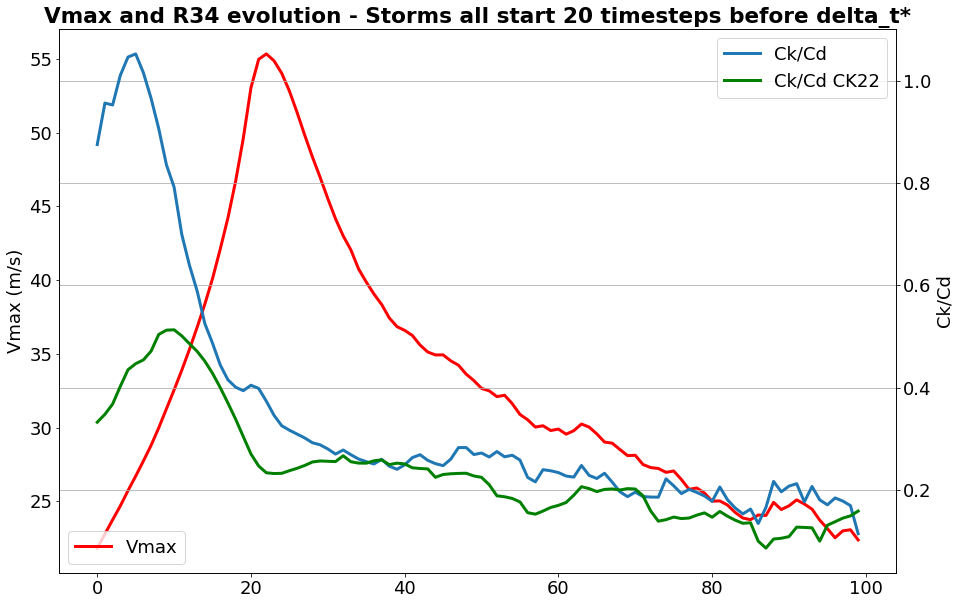

In [17]:
### Ck/Cd EVOLUTION
# Compute Ck/Cd with ER11 on the mean parameters
# NB: Computing Ck/Cd for every TC life cycles and then averaging is too time-consuming
fcor_abs            = np.abs(f.coriolis(ds_final['usa_lat']))
f_mean              = fcor_abs.mean(dim='storm', skipna=True)
ER11_SAR_ratio_mean = rmax_mean  * 1000 * vmax_mean / (r34_mean * 1000 * 17.5 + 0.5 * f_mean * ((r34_mean * 1000) ** 2))
ER11SRM_plus_rmax_s = (rmax_mean + rmax_std) * 1000 * vmax_mean / (r34_mean * 1000 * 17.5 + 0.5 * f_mean * ((r34_mean * 1000) ** 2))
ER11SRM_moin_rmax_s = (rmax_mean - rmax_std) * 1000 * vmax_mean / (r34_mean * 1000 * 17.5 + 0.5 * f_mean * ((r34_mean * 1000) ** 2))
ER11SRM_ck22        = rck22_mean * 1000 * vmax_mean / (r34_mean * 1000 * 17.5 + 0.5 * f_mean * ((r34_mean * 1000) ** 2))
Ck_Cd_mean          = f.fit_Ck_Cd_eq38(ER11_SAR_ratio_mean)
Ck_Cd_plus_s        = f.fit_Ck_Cd_eq38(ER11SRM_plus_rmax_s)
Ck_Cd_moin_s        = f.fit_Ck_Cd_eq38(ER11SRM_moin_rmax_s)
Ck_Cd_ck22          = f.fit_Ck_Cd_eq38(ER11SRM_ck22)

# # Verification of fit
# alpha = np.linspace(0.05, 1.5, 50)
# fun   = (0.5 * alpha) ** (1 / (2 - alpha))
# plt.title('Ck / Cd fit verification (colored by Rmax / R17)', weight='bold')
# plt.plot(alpha, fun, label='(0.5a) ^ 1 / (2 - a) where a = Ck / Cd')
# plt.grid();plt.legend()
# plt.xlabel('Fitted Ck / Cd');plt.ylabel('Rmax Vmax / (17.5 R17 + 0.5 f R17^2)')
# plt.scatter(Ck_Cd_mean, ER11_SAR_ratio_mean)

### SAME WITHOUT STD
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
plt.title('Vmax and R34 evolution - Storms all start 20 timesteps before delta_t*', weight='bold')
ax1.plot(vmax_mean, linewidth=3,  c='r', label='Vmax')
ax2.plot(Ck_Cd_mean, linewidth=3, c='tab:blue', label='Ck/Cd')
# ax2.fill_between(np.arange(len(Ck_Cd_mean)), Ck_Cd_plus_s, Ck_Cd_moin_s, alpha=0.3, color='tab:blue')
ax2.plot(Ck_Cd_ck22, linewidth=3, c='g',        label='Ck/Cd CK22')
# ax2.plot(rmax_mean, linewidth=3, c='k', label='Rmax IBTrACS')
ax2.legend(loc=0);ax1.legend(loc=3)
plt.xlabel('datetime');ax2.set_ylabel('Ck/Cd');ax1.set_ylabel('Vmax (m/s)')
plt.grid()